# Assignment 5

## 1 (a)
Say I was planning to pick up running again on 1 August 2013. Assuming that I did so (and managed to keep at it), while not doing any of the other specific activities tracked in the model, what is the prediction (mean ± standard-deviation) for my bodyweight (relative to 0 on 4 March 2009, the first datum in the dataset) for 31 Dec 2013? (Use the features and model as presented in the lecture)

## 1 (b)
Given the model as used in the lecture, what is the joint posterior over the 5 parametric feature weights given the data? Given an intuitive explanation for the covariance structure of this posterior (you may find it helpful to consider the plot produced in the cell titled “plot of the features” in the notebook).

In [1]:
import numpy as np
from numpy.linalg import cholesky, solve
from numpy.random import randn 
from scipy.linalg import cho_solve, cho_factor 
from scipy.io import loadmat         # because the data is in matlab format
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.dates import date2num, num2date
from datetime import datetime

# colors:
dark  = np.array([51.,51.,51.]) / 255.;
red   = np.array([141.,45.,57.]) / 255.;
gold  = np.array([174.,159.,109.]) / 255.;
gray  = np.array([175.,179.,183.]) / 255.;
lred  = np.array([1,1,1]) - 0.5 * (np.array([1,1,1]) - red);
lgold = np.array([1,1,1]) - 0.5 * (np.array([1,1,1]) - gold);

plt.rcParams['figure.figsize'] = 40, 10

## Load Data

In [2]:
data = loadmat('weightdata_clean.mat');
X = data['dat'][:,0] - 366; # python is 0-based, matlab 1-based, so we have to subtract one year and one day
Y = data['dat'][:,1]
# secretkey = Y[0];  # for anomymity (this is just a shift, it will not change the outcome of the analysis)
# Y = Y - secretkey
N = X.size

sigma = 0.1 # precision of scale (=100g), used as std-dev of measurements. 
# (No need to learn this, it's printed on the back of the scale)

In [3]:
Xd= num2date(X)    # for plotting vs human-readable dates

t = np.linspace(X[0], X[-1]+365, int(X[-1]-X[0]+1)+365); # one prediction for each day, extrapolate for one year
Nt= t.size
td= num2date(t);

## The model: GP for variability, features for causal effects

We will assume that the observed behaviour stems from a sum of separate components
\begin{align}
f(t) &= f_{SE}(t) + f_{W}(t) + f_{run}(t) + \dots f_{veg}(t)  \tag{$\star$}\\
&= \begin{bmatrix} 1 & 1 & \cdots & 1 \end{bmatrix} 
\begin{bmatrix} f_{SE}(t) \\ f_{W}(t) \\ \vdots \\ f_{veg}(t) \end{bmatrix},\\
\text{where}\qquad
f_{SE} &\sim \mathcal{GP}(0,k_{SE})\\
f_{W} &\sim \mathcal{GP}(0,k_{W}) \text{ are noise processes, and}\\
f_{run}(t) &= \phi^T _{run}(t) w_{run}\\
\end{align}
etc. for each activity. We will assume Gaussian priors and likelihood 
$$p(w) = \mathcal{N}(w;0,\operatorname{diag}(\vec{\theta}^2)$$
$$p(Y | f) = \mathcal{N}(Y;f_T,\sigma^2 I)$$

#### the time ranges of the tracked activities
__Add here the time for the prospective running activity__

In [9]:
# time frame of running
runstart1   = date2num(datetime(2009,7,1));
runend1     = date2num(datetime(2009,12,5));

# time frame of first diet
dietstart1 = date2num(datetime(2009,3,4));
dietend1   = date2num(datetime(2009,4,15));
# second diet
dietstart2 = date2num(datetime(2011,1,1));
dietend2   = date2num(datetime(2011,5,30));

# time frame of gym
gymstart   = date2num(datetime(2012,4,1));
gymend     = max(X); 

# eating vegetarian
vegstart   = date2num(datetime(2013,5,13));
vegend     = date2num(datetime(2013,6,27));

# gorgeing
eatstart1  = date2num(datetime(2009,12,5));
eatend1    = date2num(datetime(2010,5,10));

eatstart2 = date2num(datetime(2011,5,30));
eatend2   = date2num(datetime(2012,4,1));

# HOMEWORK 1 (a) running feature also for 01-08-2013 to 31-12-2013
runstart2  = date2num(datetime(2013,8,1));
runend2    = date2num(datetime(2013,12,31));

#### and features

* All weights will be interpreted in units of *grams per day*
* The choice of linear features is deliberate. Exercise: Criticically evaluate this choice and suggest alternatives

__Modify the feature for running for the additional timespan__

In [10]:
phi_run  = lambda t : ( (t > runstart1) * (t < runend1) * (t - runstart1) + (t >= runend1) * (runend1 - runstart1) ) / 1000.\
                    + ( (t > runstart2) * (t < runend2) * (t - runstart2) + (t >= runend2) * (runend2 - runstart2) ) / 1000.
phi_diet = lambda t : ( (t > dietstart1) * (t < dietend1) * (t - dietstart1) + (t >= dietend1) * (dietend1 - dietstart1) \
    + (t > dietstart2) * (t < dietend2) * (t - dietstart2) + (t >= dietend2) * (dietend2 - dietstart2) ) / 1000.
phi_eat  = lambda t : ( (t > eatstart1) * (t < eatend1) * (t - eatstart1) + (t >= eatend1) * (eatend1 - eatstart1) \
    + (t > eatstart2) * (t < eatend2) * (t - eatstart2) + (t >= eatend2) * (eatend2 - eatstart2) ) / 1000.
phi_veg  = lambda t : ( (t > vegstart) * (t < vegend) * (t - vegstart) + (t >= vegend) * (vegend - vegstart) ) / 1000.
phi_gym  = lambda t : ( (t > gymstart) * (t < gymend) * (t - gymstart) + (t >= gymend) * (gymend - gymstart) ) / 1000.

plot of the features: __Note that the running feature has been turned on for 01-08-13 to 31-12-13__

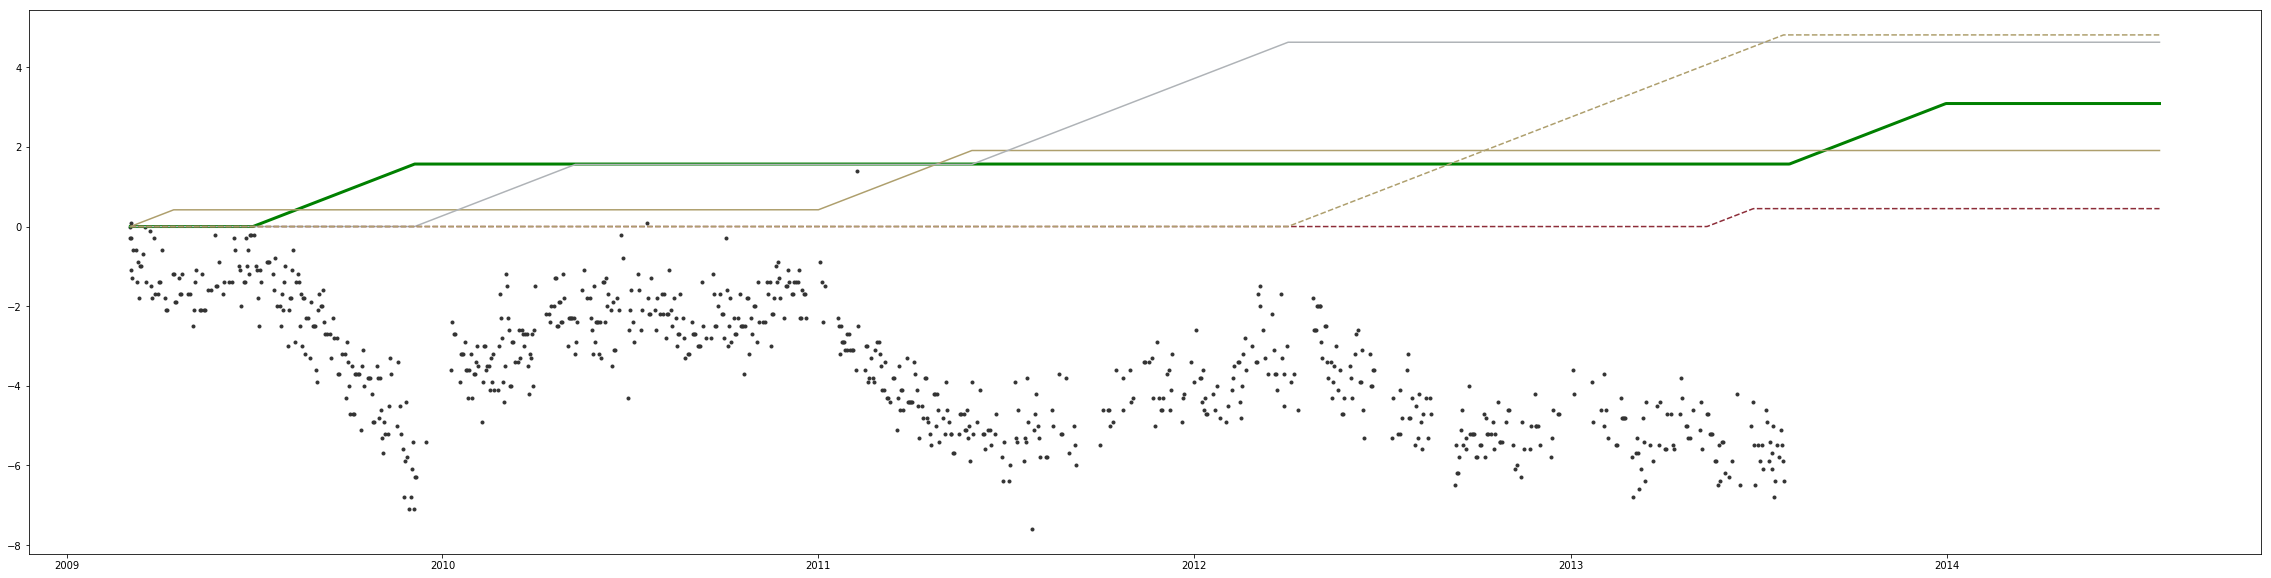

In [11]:
plt.rcParams['figure.figsize'] = 40, 10
fig = plt.figure();
plt.plot_date(Xd,Y,'.',color=dark);

plt.plot(t,10 * phi_run(t),'-',color='g', lw=3);
plt.plot(t,10 * phi_diet(t),'-',color=gold);
plt.plot(t,10 * phi_eat(t),'-',color=gray);
plt.plot(t,10 * phi_veg(t),'--',color=red);
plt.plot(t,10 * phi_gym(t),'--',color=gold);

## define overall kernel (with derivatives, for hyperparameter optimization)

In [12]:
def kernel (f) : return lambda a,b : np.array([ [np.float64(f(a[i],b[j])) for j in range(b.size) ] for i in range(a.size) ])

def weight_kernel (a,b,hypers):
    '''
        weight kernel takes in inputs 
        a,b       kernel inputs in |R
        hypers    kernel hyperparamters, in |R^8, interpreted as
        hypers = log([ell_SE,tSE,tW,trun,tveg,tdiet,tgym,teat])
        
            ell_SE — length scale of stationary noise
            tSE    – signal std-dev of stationary noise
            
            tW     – signal std-dev of random walk noise
            
            trun
            ... 
            teat   – signal std-dev of the individual lifestyle choices effects 
            
        (we use logarithmic re-scaling of hyperparameters 
        to ensure positivity, use full float range)
    '''
    [ell_SE,tSE,tW,trun,tveg,tdiet,tgym,teat] = np.exp(hypers) 
   
    # square exponential kernel
    # a stationary component, modeling a smooth mean-reverting process (digestion)
    SE  = lambda a,b : np.exp(-(a-b)**2 / 2.0 / ell_SE**2) / 1000**2 # to get units of grams per day
    kSE = kernel(SE)
    
    # Wiener process
    # a random walk as a second, additive noise process 
    # this will model unexpected events in life, such as forgetting to have lunch
    # one day, attending a wedding the next. 
    offset = min(t) - 1.0
    Wiener = lambda a,b : np.minimum(a-offset,b-offset) / 1000**2 # to get units of grams per day
    kW = kernel(Wiener)
  
    kSEab   = kSE(a,b)
    kWab    = kW(a,b)

    # kernels for the individual activities (scales are handled below)
    krunab  = np.outer(phi_run(a),phi_run(b))   # phi_r * phi_r.T
    kdietab = np.outer(phi_diet(a),phi_diet(b)) # as above
    kvegab  = np.outer(phi_veg(a),phi_veg(b))
    kgymab  = np.outer(phi_gym(a),phi_gym(b))
    keatab  = np.outer(phi_eat(a),phi_eat(b))
    
    # the overall kernel is the SUM of individual components, 
    # encoding the assumption that the weight development is a sum of 
    # separate causal effects for the lifestyle choices, and the two noise processes
    # the hyperparameters come in here
    kab   = tSE**2 * kSEab + tW**2 * kWab \
        + trun**2 * krunab + tdiet**2 * kdietab \
        + tveg**2 * kvegab + tgym**2 * kgymab \
        + teat**2 * keatab 
    
    return kab

### Load optimal hyperparameters from the lecture
(for better readability; optimization would yield the same result as there is no data in the timespan we're looking at)

In [13]:
opt_hypers = np.asarray([-0.46511258,  6.4523977 ,  4.49591588,  3.40726485, -2.25767155, 3.24235464,  1.18865219,  2.39559554])

## Prediction

In [14]:
kXX = weight_kernel(X,X,opt_hypers)
ktt = weight_kernel(t,t,opt_hypers)
ktX = weight_kernel(t,X,opt_hypers)

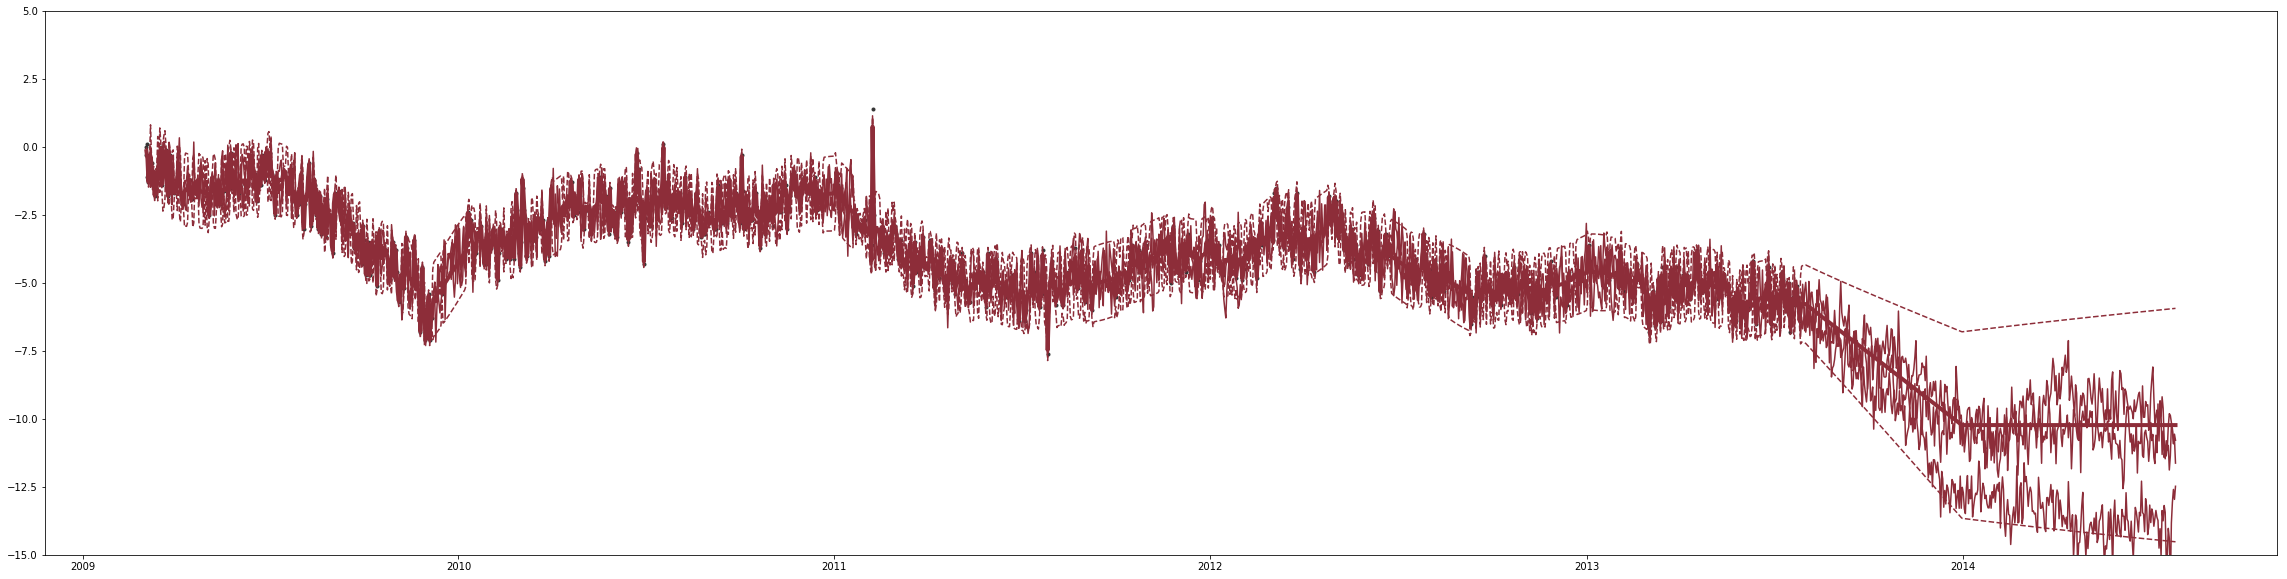

In [15]:
alpha = solve(kXX + sigma**2 * np.eye(N),ktX.T).T   # the expensive bit
mpost = alpha @ Y               # posterior mean
vpost = ktt - alpha @ ktX.T     # posterior covariance
spost = np.sqrt(np.diag(vpost)) # `sausage of uncertainty'
samples = cholesky(vpost + 1e-9 * np.eye(Nt)) @ randn(Nt,3) + mpost.reshape(Nt,1)

fig = plt.figure();

plt.plot_date(Xd,Y,'.',color=dark);
plt.plot(t,mpost,'-',color=red,lineWidth=4)
plt.plot(t,mpost + 2 * spost,'--',color=red)
plt.plot(t,mpost - 2 * spost,'--',color=red)
plt.plot(t,samples,'-',color=red)

plt.ylim([-15,5]);

### Predictive mean and std. dev. for 1 (a)

In [18]:
# find index that corresponds to 31-12-13 (which only works because we do one prediction per day)
idx = int(date2num(datetime(2013,12,31)) - X[0])

print('The predictive weight on 31-12-2013 when running for the rest of 2013 is {:3.3} kg +/- {:2.2} kg'.format(mpost[idx],3*spost[idx]))

The predictive weight on 31-12-2013 when running for the rest of 2013 is -10.2 kg +/- 5.1 kg


## Computing the posterior over the feature weights is:

The posterior over the features is
\begin{align}
p(w| Y) &= \mathcal{N}\bigg(w;\quad \operatorname{diag}(\theta^2) \Phi_X ^T G^{-1}Y,  
\quad \operatorname{diag}(\theta^2) \left(I - \Phi_X ^T G^{-1} \Phi_X \operatorname{diag}(\theta^2)\right) \bigg)
\end{align}
where $G = K_{XX} + \sigma^2 I$

Posterior mean:
[-2.93201493e+01 -2.47437573e+01 -2.03490521e+00 -2.29595418e-04
  1.02370154e+01]
Posterior variance:
[5.20884962e+01 4.37723393e+01 6.63094863e+00 1.09393780e-02
 1.58775370e+01]


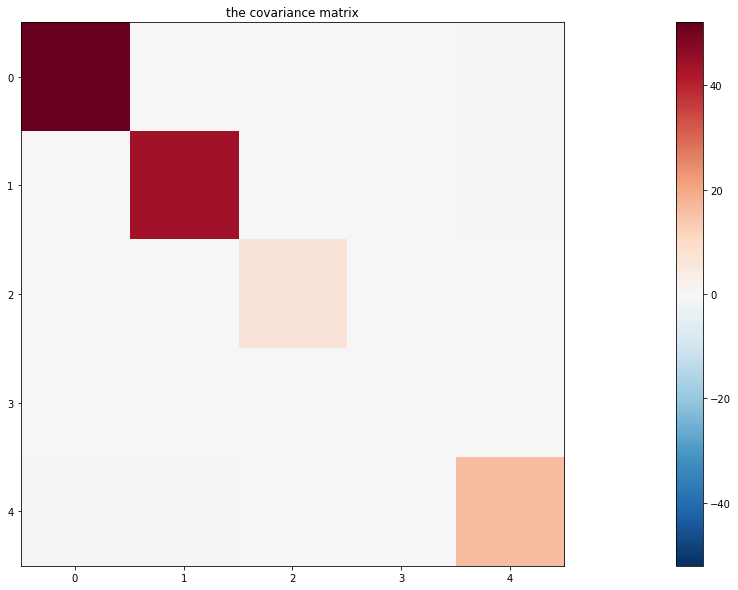

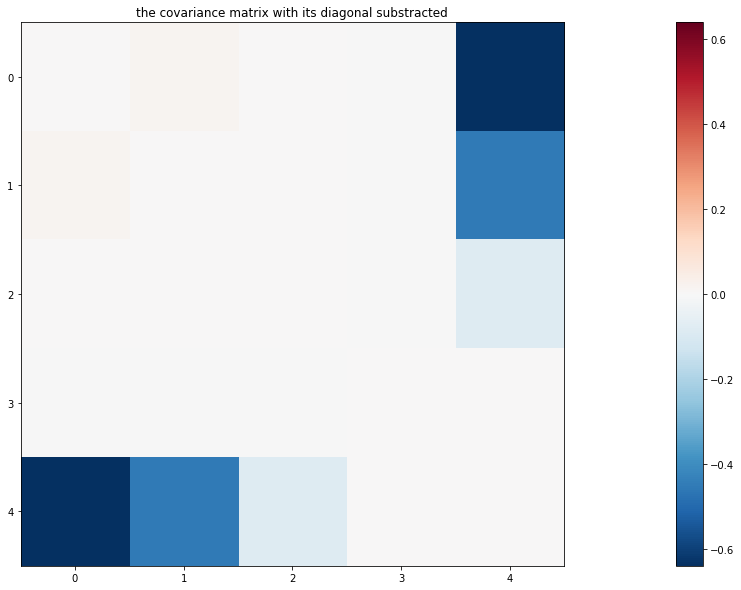

In [19]:
[ell_SE,tSE,tW,trun,tveg,tdiet,tgym,teat] = np.exp(opt_hypers)

phiX = np.array([phi_run(X), phi_diet(X), phi_gym(X), phi_veg(X), phi_eat(X)]).T
feat_params = np.diag([trun,tdiet,tgym,tveg,teat])**2
cholK = cho_factor(kXX + sigma**2 *np.eye(N))

# kernel weights (G^-1 Y)
alpha       = cho_solve(cholK,Y)

# predictive mean for the weights
mpost = feat_params @ phiX.T @ alpha

# predictive covariances
covpost = feat_params - feat_params @ phiX.T @ cho_solve(cholK,phiX) @ feat_params

print("Posterior mean:")
print(mpost)
print("Posterior variance:")
print(np.diag(covpost))

limit = np.amax(np.absolute(covpost))
plt.imshow(covpost, cmap='RdBu_r', vmin=-limit, vmax=limit)
plt.colorbar()
plt.title('the covariance matrix')
plt.show()

limit = np.amax(np.absolute(covpost - np.diag(np.diag(covpost))))
plt.imshow(covpost - np.diag(np.diag(covpost)), cmap='RdBu_r', vmin=-limit, vmax=limit)
plt.colorbar()
plt.title('the covariance matrix with its diagonal substracted')
plt.show()

#### Discussion of the covariance matrix
The diagonal elements indicate the variance of the individual weights. The off-diagonals show the correlation between the weights. We can see there that phi_eat is negatively correlated with all features except for phi_veg. However, the mean value and the variance of phi_veg is really small, since there is very little data about this.